In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('Comments_data.csv')
df = df.iloc[:, 1:3]
df = df.dropna()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = []
for x in df['Comment']:
  X.append([x])

In [ ]:
y = []
for i in df['Label']:
  y.append(i)

In [ ]:
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('훈련용 리뷰 개수 :',len(train_X)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(y_train)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 47873
테스트용 리뷰 개수 : 47873


In [ ]:
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 3.8MB 44.4MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#이모티콘 제거
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

#분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d]')

In [ ]:
def preprocess(s):
  comment_result = []
  for comment in s:
      tokens = re.sub(emoji_pattern,"",comment[0])
      tokens = re.sub(han,"",tokens)
      comment_result.append([tokens])
  return comment_result 

In [ ]:
train_X = preprocess(train_X)
test_X = preprocess(test_X)

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
X_train = []
for sentence in train_X:
    temp_X = []
    temp_X = okt.morphs(sentence[0], stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    print(temp_X)
    X_train.append(temp_X)

In [ ]:
X_test = []
for sentence in test_X:
    temp_X = []
    temp_X = okt.morphs(sentence[0], stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32674
등장 빈도가 2번 이하인 희귀 단어의 수: 19495
단어 집합에서 희귀 단어의 비율: 59.66517720511722
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.034173246104934


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 13181


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[152, 5427, 1, 24, 1653, 4, 187, 62, 944, 600, 21, 418, 1022, 7, 7391, 5428, 4], [9, 10835, 5, 47, 121, 14], [99, 2000, 337, 5]]


빈 샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

47464
47464


패딩

리뷰의 최대 길이 : 1765
리뷰의 평균 길이 : 12.517887240856227


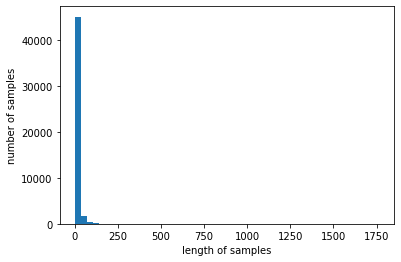

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.81771447834149


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier


model1 = RandomForestClassifier(n_estimators=100, n_jobs=10)
model1.fit(X_train, y_train)
model1.fit(X_test, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=10, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
r1 = model1.score(X_train, y_train)
r1

0.9392170908478005

In [ ]:
r2 = model1.score(X_test, y_test)
r2

0.9981967053319037

In [ ]:
y_pred = model1.predict(X_train)
y_pred

array([0., 0., 2., ..., 0., 0., 0.])

In [ ]:
print("훈련셋 정확도 : {:.3f}".format(model1.score(X_train,y_train)))

print("테스트셋 정확도 : {:.3f}".format(model1.score(X_test,y_test)))

훈련셋 정확도 : 0.996
테스트셋 정확도 : 0.938


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

s1 = StandardScaler()
s2 = RobustScaler()
s3 = MinMaxScaler()
s4 = Normalizer()



In [ ]:
s1.fit(X)
s2.fit(X)
s3.fit(X)
s4.fit(X)

ValueError: ignored

In [ ]:
from sklearn.svm import SVC
model001 = SVC()
model002 = SVC()
model003 = SVC()
model004 = SVC()
model005 = SVC()

model001.fit(X_train, y_train)
model002.fit(X_train1, y_train)
model003.fit(X_train2, y_train)
model004.fit(X_train3, y_train)
model005.fit(X_train4, y_train)

In [ ]:

data(r1)
plot(randomForest(mpg  ., mtcars, keep.forest=FALSE, ntree=100), log="y")


SyntaxError: ignored

In [ ]:
plt.plot(['recall'], label = 'recall')
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['precision'], label = 'precision')
plt.legend(['recall','accuracy','precision'])
plt.title('Random Forest')
plt.show()

NameError: ignored

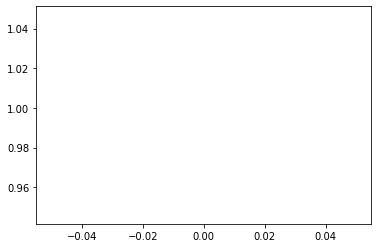

In [ ]:
plt.plot(r1, label='random')

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model1.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('행복하세요')

100.00% 확률로 긍정 리뷰입니다.



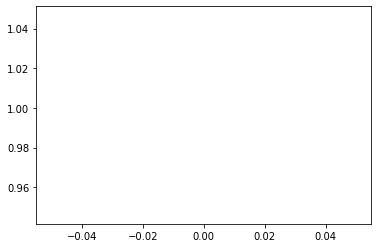

In [ ]:
plt.plot(history.history['recall'], label = 'recall')
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['precision'], label = 'precision')
plt.legend(['recall','accuracy','precision'])
plt.title('Random Forest')
plt.show()

결정트리

In [ ]:
from sklearn.tree import DecisionTreeClassifier


model2 = DecisionTreeClassifier(max_depth=50)
model2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
a1 = model2.score(X_train, y_train)
a2 = model2.score(X_test, y_test)
print(a1)
print(a2)

0.9900134839035901
0.8863924359099328


In [ ]:
y_pred = model2.predict(X_test)
y_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) 
  new_sentence = [word for word in new_sentence if not word in stopwords] 
  encoded = tokenizer.texts_to_sequences([new_sentence]) 
  pad_new = pad_sequences(encoded, maxlen = max_len) 
  score = float(model2.predict(pad_new)) 
  if(score > 0.5):
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('잘한다')

100.00% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('쓰레기 새끼야')

100.00% 확률로 긍정 리뷰입니다.



최근접 이웃


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
model10 = KNeighborsClassifier(n_neighbors=10)
model10.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
k1 = model10.score(X_test, y_test)
k1


0.9393703089969783

In [ ]:
k2 = model10.score(X_train,y_train)
k2

0.9403337266138547

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.flow(k2, label='KNeighborsClassifier')
plt.legend()

NameError: ignored

K폴드 교차검증

In [ ]:
from sklearn.preprocessing import StandardScaler

s1 = StandardScaler()
s1.fit(X_train)
X_train = s1.transform(X_train)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifierpt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Fold 생성 : 데이터를 섞어서 가지고 있는 데이터 꾸러미
fold = KFold(n_splits=10, shuffle=True)


model01 = KNeighborsClassifier()
model02 = LogisticRegression()
model03 = DecisionTreeClassifier()
model04 = RandomForestClassifier()

score1 = cross_val_score(model01, X_train, y_train,
                        cv=fold, scoring='accuracy')
score2 = cross_val_score(model02, X_train, y_train,
                        cv=fold, scoring='accuracy')
score3 = cross_val_score(model03, X_train, y_train,
                        cv=fold, scoring='accuracy')
score4 = cross_val_score(model04, X_train, y_train,
                        cv=fold, scoring='accuracy')

In [ ]:
plt.plot(score1, label='model01')
plt.plot(score2, label='model02')
plt.plot(score3, label='model03')
plt.plot(score4, label='model04')
plt.legend()